# Segmentación Semántica con DeepLabv3+

**Autora:** Julia García Vega

**Fecha:** 02/07/2024

**Descripción:** Implementación de la arquitectura DeepLabv3+ para la segmentación semántica de múltiples clases.


## Configuración inicial

In [1]:
# para cargar los datos
import os
!pip install roboflow
from roboflow import Roboflow

# para leer y procesar imágenes
import imageio
from PIL import Image

# para trabajar con arrays
import numpy as np

# para visualizaciones de imágenes y gráficos
import matplotlib.pyplot as plt

# para la generación de números aleatorios
import random

# para construir y ejecutar modelos de aprendizaje profundo
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50

# para descargar el fichero del modelo resultante
from google.colab import files

# para métricas de evaluación de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score, accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.4 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycle

In [2]:
CLASSES_NAMES = ['fondo', 'acera', 'baldosas podotáctiles', 'banco', 'carretera', 'pared', 'paso de cebra', 'vegetación']
BACKGROUND = [255,255,255]
SIDEWALK = [155, 155, 155]
PODOTACTILE_PAVEMENT = [255, 89, 94]
BENCH = [255, 146, 76]
ROAD = [28, 48, 74]
WALL = [255, 202, 58]
CROSSWALK = [25, 130, 196]
VEGETATION = [138, 201, 38]
COLOR_DICT = np.array([BACKGROUND, SIDEWALK, PODOTACTILE_PAVEMENT, BENCH, ROAD, WALL, CROSSWALK, VEGETATION])
TARGET_SHAPE_IMG = [128, 128, 3]
TARGET_SHAPE_MASK = [128, 128, 1]
BATCH_SIZE = 32
NUM_CLASSES = 8
TRAIN_DIR = '/content/Elementos-acera-2-12/train/'
VALID_DIR = '/content/Elementos-acera-2-12/valid/'
TEST_DIR = '/content/Elementos-acera-2-12/test/'

In [3]:
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = COLOR_DICT
    if np.max(label) > len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

## Importación de los datos

Se procede a descargar el conjunto de datos del proyecto personal de Roboflow en el que se ha llevado acabo la anotación de las imágenes. Está compuesto por 5217 y se distinguen las siguientes clases:

*   Fondo
*   Acera
*   Baldosas podotáctiles
*   Banco
*   Carretera
*   Pared
*   Paso de cebra
*   Vegetación

In [4]:
# IMPORTANTE: La siguiente línea contiene la API key de Roboflow, la cual ha sido reemplazada por asteriscos por motivos de seguridad.
# En caso de necesitar acceso a la API key original para la reproducción o evaluación del trabajo, por favor, solicitarla a juliagarve@usal.es.

rf = Roboflow(api_key="********************")
project = rf.workspace("tfg-nrlv7").project("elementos-acera-2")
dataset = project.version(12).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Elementos-acera-2-12 in png-mask-semantic:: 100%|██████████| 11926/11926 [00:01<00:00, 6054.84it/s]


In [5]:
def LoadData (path):
    """
    Carga los datos devolviendo dos listas, una con los nombres de los ficheros
    de imágenes y otra con los nombres de los ficheros de las máscaras
    """
    #Obtener un listado de los archivos en esa ubicación
    dataset = os.listdir(path)

    #Filtrar respectivamente las imágenes (archivos .jpg) y las máscaras (archivos .png)
    image_dataset = [file_name for file_name in dataset if file_name.endswith('.jpg')]
    mask_dataset = [file_name for file_name in dataset if file_name.endswith('.png')]

    # Ordenar ambas listas para que tengan en el mismo índice la imagen y máscara correspondiente
    image_dataset.sort()
    mask_dataset.sort()

    return image_dataset, mask_dataset

train_image_dataset, train_mask_dataset = LoadData(TRAIN_DIR)
valid_image_dataset, valid_mask_dataset = LoadData(VALID_DIR)
test_image_dataset, test_mask_dataset = LoadData(TEST_DIR)

In [6]:
NUM_TRAIN_IMAGES = len(train_mask_dataset)
NUM_VALID_IMAGES = len(valid_mask_dataset)
NUM_TEST_IMAGES = len(test_mask_dataset)

print("Número imágenes entrenamiento: ", NUM_TRAIN_IMAGES)
print("Número imágenes validación: ", NUM_VALID_IMAGES)
print("Número imágenes test: ", NUM_TEST_IMAGES)

Número imágenes entrenamiento:  5217
Número imágenes validación:  495
Número imágenes test:  247


Inicialmente, debido a que se consideraron dos clases adicionales (escaleras de subida y escaleras de bajada), al eliminarlas y extraer el conjunto de datos de Roboflow los valores enteros correspondientes con cada clase quedaron descuadrados siendo asignadas por Roboflow de la siguiente manera [0, 1, 2, 3, 4, 7, 8, 9] como se puede observar a continuación. Por ello, se procede a corregir este hueco en la secuencia sustituyendo la clase 7 por la clase 5, la clase 8 por la clase 6 y la clase 9 por la clase 7.

In [7]:
def testUniqueValues(path, mask_dataset):
    """
    Comprueba los valores únicos existentes en las máscaras
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en todo el conjunto de imágenes:")
    print(unique_total_values)

In [8]:
def adjustUniqueValues(path, mask_dataset):
    """
    Ajusta los valores únicos existentes en las máscaras para corregir la falta de clases
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Reemplazar los valores 7, 8 y 9 por 5, 6 y 7 respectivamente
        image = np.where(image == 7, 5, image)
        image = np.where(image == 8, 6, image)
        image = np.where(image == 9, 7, image)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

        # Guardar la imagen modificada en la misma ubicación con el mismo nombre
        imageio.imwrite(image_path, image)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en todo el conjunto de imágenes:")
    print(unique_total_values)

In [9]:
testUniqueValues(TRAIN_DIR, train_mask_dataset)
testUniqueValues(VALID_DIR, valid_mask_dataset)
testUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]


In [10]:
adjustUniqueValues(TRAIN_DIR, train_mask_dataset)
adjustUniqueValues(VALID_DIR, valid_mask_dataset)
adjustUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]


## Visualización de imágenes y su máscara correspondiente

Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)
Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)


Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


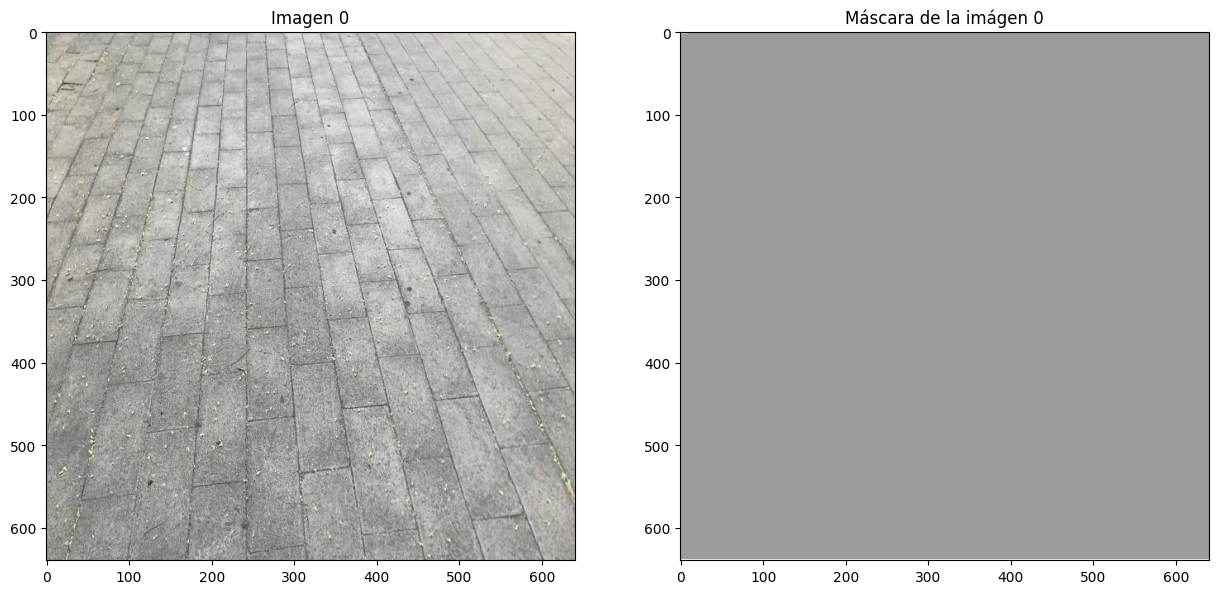

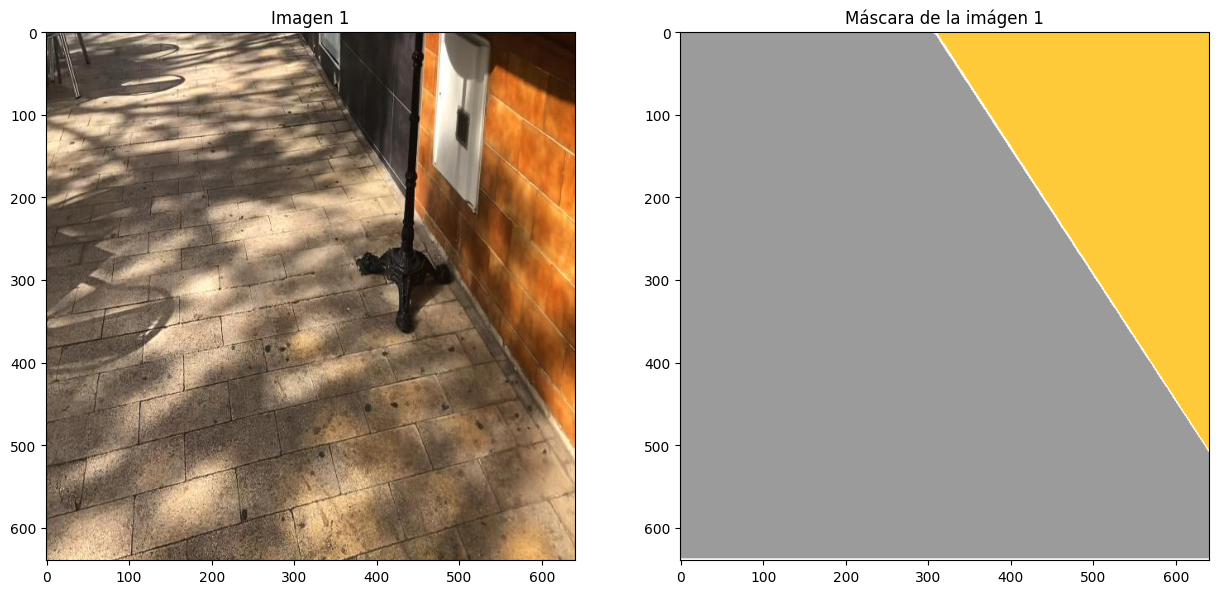

In [11]:
show_images = 2
random_ints = np.random.randint(0, NUM_TRAIN_IMAGES - 1, size=show_images)
for index, num in enumerate(random_ints):
    img_view  = imageio.imread(TRAIN_DIR + train_image_dataset[num])
    mask_view = imageio.imread(TRAIN_DIR + train_mask_dataset[num])
    mask_view_color = label_to_color_image(mask_view).astype(np.uint8)
    print("Dimensión imágen: ", img_view.shape)
    print("Dimensión máscara: ", mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Imagen '+ str(index))
    arr[1].imshow(mask_view_color)
    arr[1].set_title('Máscara de la imágen '+ str(index))

## Preprocesamiento del conjunto de datos


In [12]:
def PreprocessData(image_dataset, mask_dataset, target_shape_img, target_shape_mask, path):
    """
    Preprocesa las imágenes y mascaras presentes en las listas y la ubicación
    pasada como argumento.
    Devuelve dos arrays de cuatro dimensiones que contienen las imágenes y máscaras
    como arrays. Las dimensiones corresponden con lo siguiente:
        Primera dimensión:              número de imágenes/máscaras
        Segunda y tercera dimensión:    ancho y alto deseado
        Cuarta dimensión:               número de canales.
                                            las imágenes 3 canales (RGB)
                                            las máscaras 1 canal (escala de grises)
    """
    # Extraer las dimensiones relevantes
    num_images = len(image_dataset)  # número de imágenes
    i_h,i_w,i_c = target_shape_img   # altura, ancho y canales de una imagen
    m_h,m_w,m_c = target_shape_mask  # altura, ancho y canales de una máscara

    # Definir X e Y como el número de imágenes junto con la dimensión de una imagen
    X = np.zeros((num_images,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((num_images,m_h,m_w,m_c), dtype=np.int32)

    # Redimensionar imágenes y máscaras
    for i in range(num_images):
        # convertir la imagen en un array con la forma deseada
        image_name = image_dataset[i]
        image_path = os.path.join(path, image_name)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((i_h,i_w))
        image = np.reshape(image,(i_h,i_w,i_c))
        X[i] = image

        # convertir la máscara en un array con la forma deseada
        mask_name = mask_dataset[i]
        mask_path = os.path.join(path, mask_name)
        mask = Image.open(mask_path)
        mask = mask.resize((m_h, m_w),Image.NEAREST) #Con flag Image.NEAREST para que no se cree una nueva clase por la interpolación de los píxeles
        mask = np.reshape(mask,(m_h,m_w,m_c))

        y[i] = mask

    return X, y

In [13]:
X_train, y_train = PreprocessData(train_image_dataset, train_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TRAIN_DIR)
X_valid, y_valid = PreprocessData(valid_image_dataset, valid_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, VALID_DIR)
X_test, y_test = PreprocessData(test_image_dataset, test_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TEST_DIR)

print("Dimensión conjunto de imágenes de entrenamiento: ", X_train.shape)
print("Dimensión conjunto de máscaras de entrenamiento: ", y_train.shape)
print("Dimensión conjunto de imágenes de validación: ", X_valid.shape)
print("Dimensión conjunto de máscaras de validación: ", y_valid.shape)
print("Dimensión conjunto de imágenes de prueba: ", X_test.shape)
print("Dimensión conjunto de máscaras de prueba: ", y_test.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

print("Dataset de entrenamiento: ", train_dataset)
print("Dataset de validación: ", valid_dataset)
print("Dataset de prueba: ", test_dataset)

Dimensión conjunto de imágenes de entrenamiento:  (5217, 128, 128, 3)
Dimensión conjunto de máscaras de entrenamiento:  (5217, 128, 128, 1)
Dimensión conjunto de imágenes de validación:  (495, 128, 128, 3)
Dimensión conjunto de máscaras de validación:  (495, 128, 128, 1)
Dimensión conjunto de imágenes de prueba:  (247, 128, 128, 3)
Dimensión conjunto de máscaras de prueba:  (247, 128, 128, 1)
Dataset de entrenamiento:  <_BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.int32, name=None))>
Dataset de validación:  <_BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.int32, name=None))>
Dataset de prueba:  <_BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.int32, name=None))>


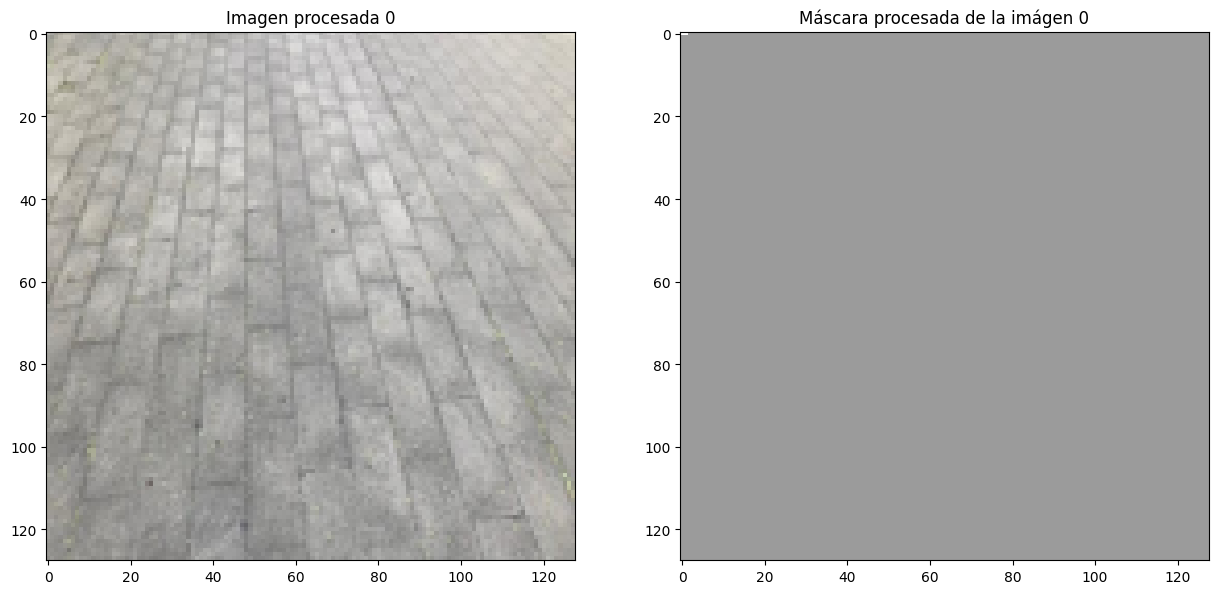

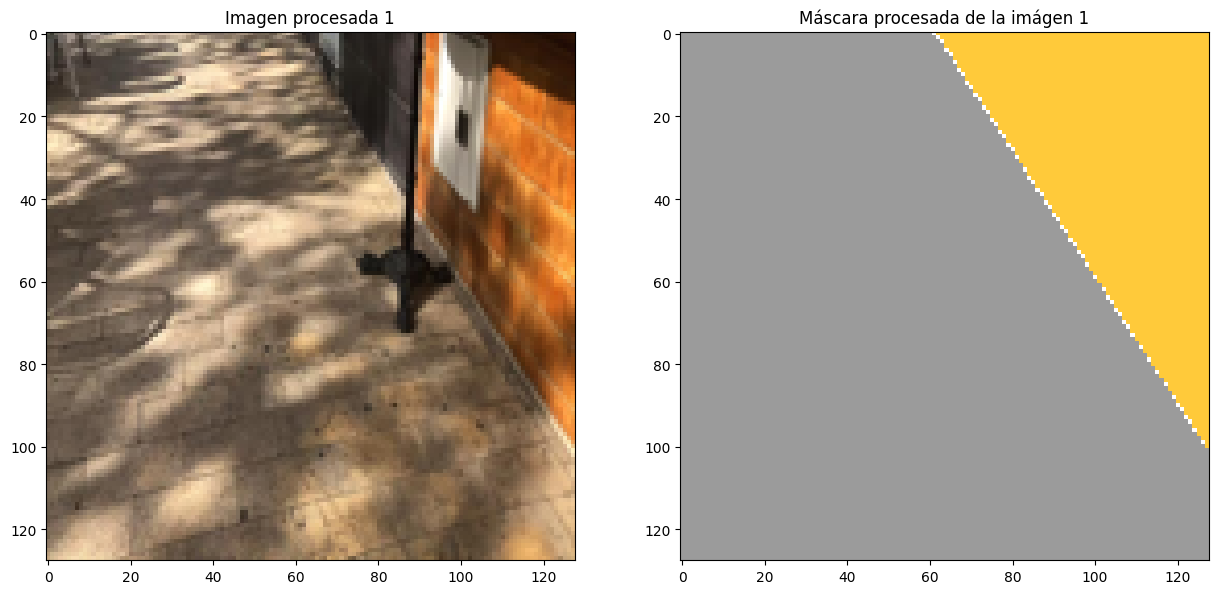

In [14]:
for index, num in enumerate(random_ints):
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X_train[num]/255.)
    arr[0].set_title('Imagen procesada '+ str(index))
    mask_view_color = label_to_color_image(y_train[num,:,:,0]).astype(np.uint8)
    arr[1].imshow(mask_view_color)
    arr[1].set_title('Máscara procesada de la imágen '+ str(index))

## Construcción de la arquitectura DeepLabv3+

Modelo adaptado de Rakshit, S. (2024). Multiclass semantic segmentation using DeepLabV3+. https://keras.io/examples/vision/deeplabv3_plus/

In [15]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer='HeNormal',
    )(block_input)
    x = BatchNormalization()(x)
    return Activation("relu")(x)

In [16]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [29]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = Input(shape=image_size)
    preprocessed = resnet50.preprocess_input(model_input)
    resnet50_model = ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50_model.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[0] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50_model.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[0] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return Model(inputs=model_input, outputs=model_output)

Se definen 4 modelos iguales para utilizar con cada una de las siguientes configuraciones:
*   Función de pérdida de entropía cruzada y optimización Adam
*   Función de pérdida de entropía cruzada y optimización SGD
*   Función de pérdida focal y optimización Adam
*   Función de pérdida focal cruzada y optimización SGD

In [37]:
model_ce_adam = DeeplabV3Plus(image_size=TARGET_SHAPE_IMG, num_classes=NUM_CLASSES)
model_ce_sgd = DeeplabV3Plus(image_size=TARGET_SHAPE_IMG, num_classes=NUM_CLASSES)
model_focal_adam = DeeplabV3Plus(image_size=TARGET_SHAPE_IMG, num_classes=NUM_CLASSES)
model_focal_sgd = DeeplabV3Plus(image_size=TARGET_SHAPE_IMG, num_classes=NUM_CLASSES)

A continuación se muestra la arquitectura detallada de los modelos

In [31]:
model_ce_adam.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_4  (None, 128, 128, 3)          0         ['input_5[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_4 (TFOpLamb  (None, 128, 128, 3)          0         ['tf.__operators__.getitem_4[0
 da)                                                                ][0]']                        
                                                                                            

## Definición de las métricas para utilizar en el entrenamiento

In [20]:
def iou(y_true, y_pred):
  y_pred = K.argmax(y_pred, axis=-1)
  y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

  y_true = K.squeeze(y_true, axis=-1)
  y_true_int = K.cast(y_true, 'int32')
  y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

  intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
  union = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3]) - intersection
  iou = (intersection + K.epsilon()) / (union + K.epsilon())
  return iou

def iou_one_hot(y_true, y_pred):
  y_pred = K.argmax(y_pred, axis=-1)
  y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

  y_true_one_hot = y_true

  intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
  union = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3]) - intersection
  iou = (intersection + K.epsilon()) / (union + K.epsilon())
  return iou

In [21]:
def dice_coef(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
    total_pixels = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3])
    dice_coef = (2 * intersection + K.epsilon()) / (total_pixels + K.epsilon())
    return dice_coef

def dice_coef_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
    total_pixels = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3])
    dice_coef = (2 * intersection + K.epsilon()) / (total_pixels + K.epsilon())
    return dice_coef

In [22]:
def precision(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    pred_positives = K.sum(y_pred_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (pred_positives + K.epsilon())
    return precision

def precision_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    pred_positives = K.sum(y_pred_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (pred_positives + K.epsilon())
    return precision

In [23]:
def recall(y_true, y_pred):

    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_pred_one_hot * y_true, axis=[1,2,3])
    truth_positives = K.sum(y_true, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (truth_positives + K.epsilon())
    return precision

def recall_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    truth_positives = K.sum(y_true_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (truth_positives + K.epsilon())
    return precision

In [24]:
def accuracy(y_true, y_pred):
    y_pred_int = K.cast(K.argmax(y_pred, axis=-1), 'int32')
    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')

    correct_predictions = K.sum(K.cast(K.equal(y_true_int, y_pred_int), dtype='float32'), axis=[1,2])
    total_pixels = K.constant(16384.0, dtype='float32')
    accuracy = (correct_predictions + K.epsilon()) / (total_pixels + K.epsilon())
    return accuracy

def accuracy_one_hot(y_true, y_pred):
    y_pred_int = K.cast(K.argmax(y_pred, axis=-1), 'int32')

    y_true_int = K.cast(K.argmax(y_true, axis=-1), 'int32')

    correct_predictions = K.sum(K.cast(K.equal(y_true_int, y_pred_int), dtype='float32'), axis=[1,2])
    total_pixels = K.constant(16384.0, dtype='float32')
    accuracy = (correct_predictions + K.epsilon()) / (total_pixels + K.epsilon())
    return accuracy

## Entrenamiento

### Pérdida focal y Adam

In [72]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)
train_dataset_one_hot = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
train_dataset_one_hot = train_dataset_one_hot.batch(BATCH_SIZE, drop_remainder=True)
valid_dataset_one_hot = tf.data.Dataset.from_tensor_slices((X_valid, y_valid_one_hot))
valid_dataset_one_hot = valid_dataset_one_hot.batch(BATCH_SIZE, drop_remainder=True)

In [73]:
model_focal_adam = DeeplabV3Plus(image_size=TARGET_SHAPE_IMG, num_classes=NUM_CLASSES)

In [74]:
model_focal_adam.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True),
              metrics=[accuracy_one_hot, iou_one_hot, dice_coef_one_hot, precision_one_hot, recall_one_hot])

results_focal_adam = model_focal_adam.fit(train_dataset_one_hot, validation_data=valid_dataset_one_hot, epochs=30)

Epoch 1/30
163/163 [==============================] - 63s 240ms/step - loss: 0.1562 - accuracy_one_hot: 0.6674 - iou_one_hot: 0.5451 - dice_coef_one_hot: 0.6674 - precision_one_hot: 0.6674 - recall_one_hot: 0.6674 - val_loss: 3.0330 - val_accuracy_one_hot: 0.0985 - val_iou_one_hot: 0.0570 - val_dice_coef_one_hot: 0.0985 - val_precision_one_hot: 0.0985 - val_recall_one_hot: 0.0985
Epoch 2/30
163/163 [==============================] - 36s 222ms/step - loss: 0.1254 - accuracy_one_hot: 0.7132 - iou_one_hot: 0.5927 - dice_coef_one_hot: 0.7132 - precision_one_hot: 0.7132 - recall_one_hot: 0.7132 - val_loss: 0.1363 - val_accuracy_one_hot: 0.7392 - val_iou_one_hot: 0.6238 - val_dice_coef_one_hot: 0.7392 - val_precision_one_hot: 0.7392 - val_recall_one_hot: 0.7392
Epoch 3/30
163/163 [==============================] - 36s 222ms/step - loss: 0.1098 - accuracy_one_hot: 0.7493 - iou_one_hot: 0.6340 - dice_coef_one_hot: 0.7493 - precision_one_hot: 0.7493 - recall_one_hot: 0.7493 - val_loss: 0.0925 -

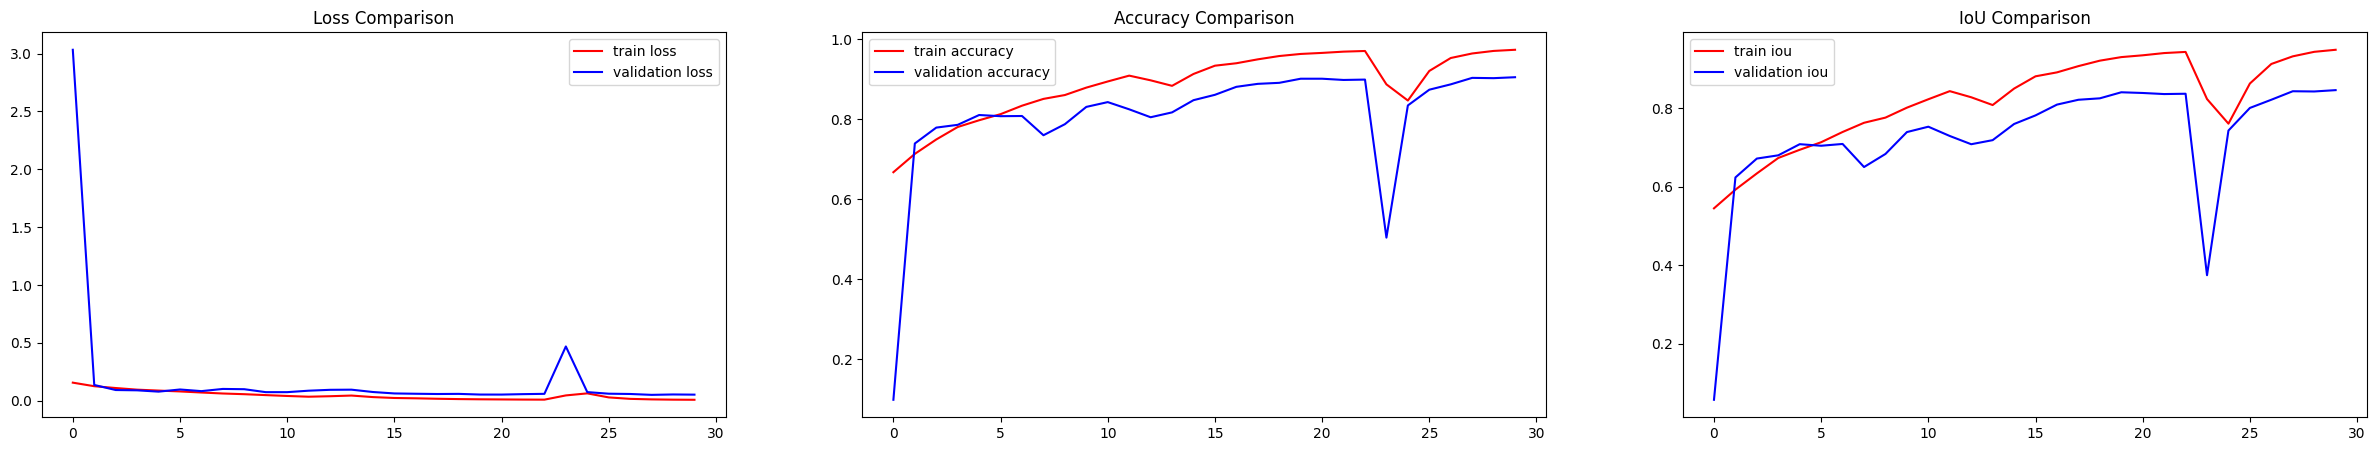

In [75]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_focal_adam.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_focal_adam.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_focal_adam.history["accuracy_one_hot"], color='r', label = 'train accuracy')
axis[1].plot(results_focal_adam.history["val_accuracy_one_hot"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_focal_adam.history["iou_one_hot"], color='r', label = 'train iou')
axis[2].plot(results_focal_adam.history["val_iou_one_hot"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Pérdida focal y SGD

In [40]:
model_focal_sgd.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True),
              metrics=[accuracy_one_hot, iou_one_hot, dice_coef_one_hot])

results_focal_sgd = model_focal_sgd.fit(train_dataset_one_hot, validation_data=valid_dataset_one_hot, epochs=30)

Epoch 1/30
163/163 [==============================] - 51s 230ms/step - loss: 0.2507 - accuracy_one_hot: 0.5406 - iou_one_hot: 0.4168 - dice_coef_one_hot: 0.5406 - val_loss: 0.1925 - val_accuracy_one_hot: 0.6560 - val_iou_one_hot: 0.5260 - val_dice_coef_one_hot: 0.6560
Epoch 2/30
163/163 [==============================] - 36s 221ms/step - loss: 0.1612 - accuracy_one_hot: 0.6784 - iou_one_hot: 0.5469 - dice_coef_one_hot: 0.6784 - val_loss: 0.1305 - val_accuracy_one_hot: 0.7425 - val_iou_one_hot: 0.6190 - val_dice_coef_one_hot: 0.7425
Epoch 3/30
163/163 [==============================] - 36s 221ms/step - loss: 0.1366 - accuracy_one_hot: 0.7186 - iou_one_hot: 0.5912 - dice_coef_one_hot: 0.7186 - val_loss: 0.1135 - val_accuracy_one_hot: 0.7676 - val_iou_one_hot: 0.6512 - val_dice_coef_one_hot: 0.7676
Epoch 4/30
163/163 [==============================] - 36s 222ms/step - loss: 0.1217 - accuracy_one_hot: 0.7439 - iou_one_hot: 0.6209 - dice_coef_one_hot: 0.7439 - val_loss: 0.1034 - val_accurac

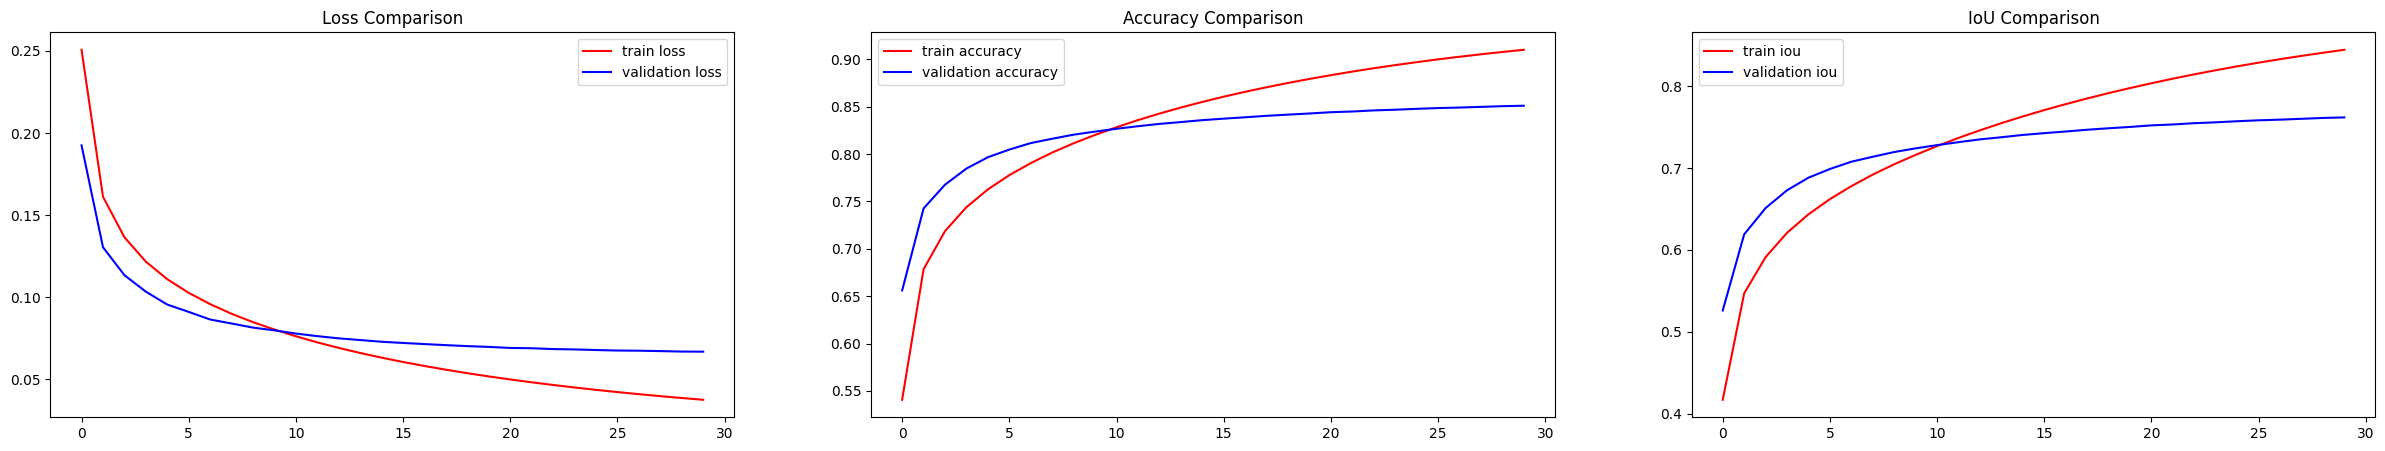

In [41]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_focal_sgd.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_focal_sgd.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_focal_sgd.history["accuracy_one_hot"], color='r', label = 'train accuracy')
axis[1].plot(results_focal_sgd.history["val_accuracy_one_hot"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_focal_sgd.history["iou_one_hot"], color='r', label = 'train iou')
axis[2].plot(results_focal_sgd.history["val_iou_one_hot"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Entropía cruzada categórica dispersa y Adam

In [42]:
model_ce_adam.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[accuracy, iou, dice_coef])

results_ce_adam = model_ce_adam.fit(train_dataset, validation_data=valid_dataset, epochs=30)

Epoch 1/30
163/163 [==============================] - 61s 223ms/step - loss: 1.0256 - accuracy: 0.6712 - iou: 0.5470 - dice_coef: 0.6712 - val_loss: 13.7880 - val_accuracy: 0.6085 - val_iou: 0.4737 - val_dice_coef: 0.6085
Epoch 2/30
163/163 [==============================] - 35s 212ms/step - loss: 0.8505 - accuracy: 0.7244 - iou: 0.6045 - dice_coef: 0.7244 - val_loss: 8.3628 - val_accuracy: 0.6983 - val_iou: 0.5857 - val_dice_coef: 0.6983
Epoch 3/30
163/163 [==============================] - 35s 214ms/step - loss: 0.7712 - accuracy: 0.7548 - iou: 0.6408 - dice_coef: 0.7548 - val_loss: 0.7496 - val_accuracy: 0.7760 - val_iou: 0.6663 - val_dice_coef: 0.7760
Epoch 4/30
163/163 [==============================] - 35s 214ms/step - loss: 0.7586 - accuracy: 0.7623 - iou: 0.6480 - dice_coef: 0.7623 - val_loss: 0.7120 - val_accuracy: 0.7965 - val_iou: 0.6866 - val_dice_coef: 0.7965
Epoch 5/30
163/163 [==============================] - 35s 214ms/step - loss: 0.6709 - accuracy: 0.7895 - iou: 0.682

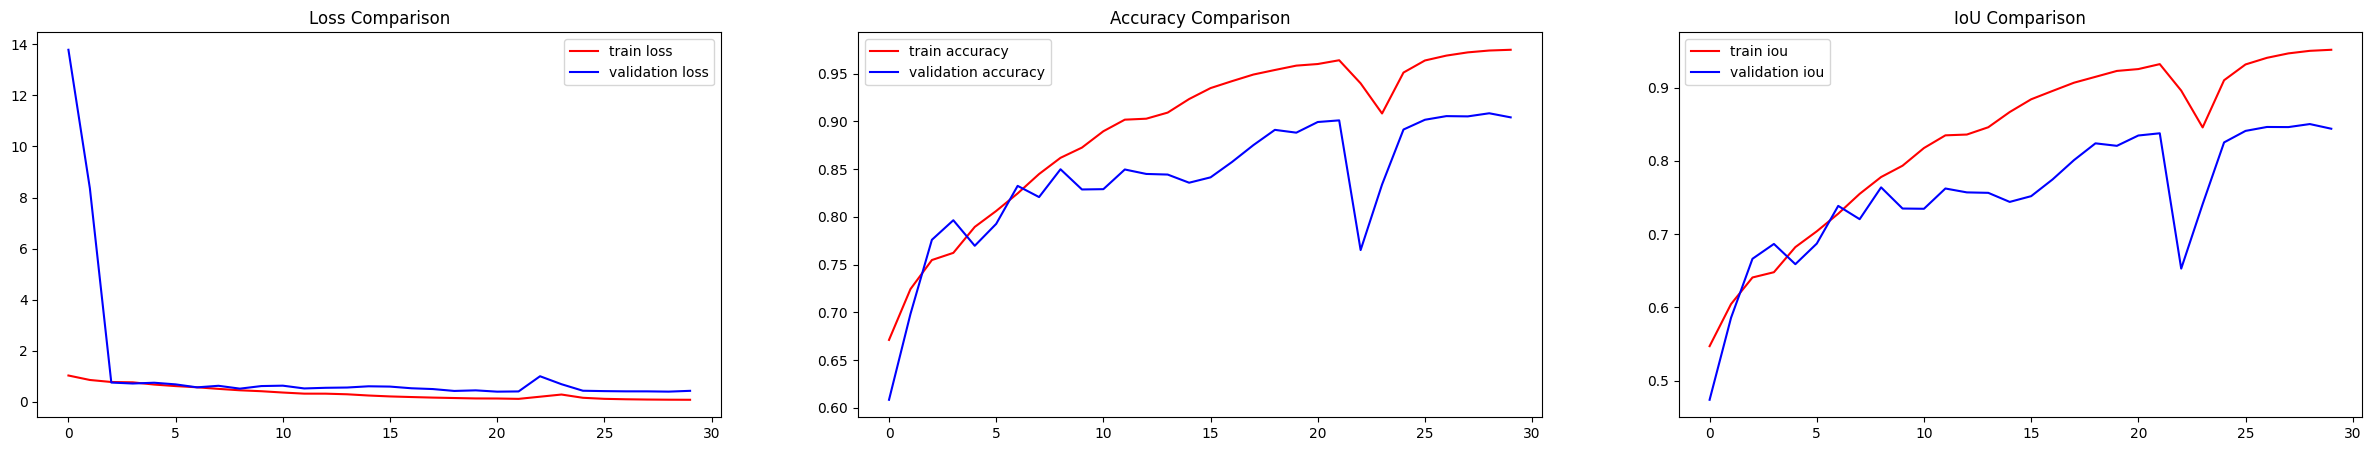

In [43]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_ce_adam.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_ce_adam.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_ce_adam.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results_ce_adam.history["val_accuracy"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_ce_adam.history["iou"], color='r', label = 'train iou')
axis[2].plot(results_ce_adam.history["val_iou"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Entropía cruzada categórica dispersa y SGD

In [44]:
model_ce_sgd.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[accuracy, iou, dice_coef])

results_ce_sgd = model_ce_sgd.fit(train_dataset, validation_data=valid_dataset, epochs=30)

Epoch 1/30
163/163 [==============================] - 49s 222ms/step - loss: 1.0599 - accuracy: 0.6708 - iou: 0.5526 - dice_coef: 0.6708 - val_loss: 0.7202 - val_accuracy: 0.8020 - val_iou: 0.6975 - val_dice_coef: 0.8020
Epoch 2/30
163/163 [==============================] - 35s 213ms/step - loss: 0.6912 - accuracy: 0.7877 - iou: 0.6792 - dice_coef: 0.7877 - val_loss: 0.5102 - val_accuracy: 0.8410 - val_iou: 0.7490 - val_dice_coef: 0.8410
Epoch 3/30
163/163 [==============================] - 35s 213ms/step - loss: 0.5629 - accuracy: 0.8289 - iou: 0.7315 - dice_coef: 0.8289 - val_loss: 0.4600 - val_accuracy: 0.8547 - val_iou: 0.7677 - val_dice_coef: 0.8547
Epoch 4/30
163/163 [==============================] - 35s 214ms/step - loss: 0.4752 - accuracy: 0.8574 - iou: 0.7697 - dice_coef: 0.8574 - val_loss: 0.4391 - val_accuracy: 0.8616 - val_iou: 0.7774 - val_dice_coef: 0.8616
Epoch 5/30
163/163 [==============================] - 35s 213ms/step - loss: 0.4101 - accuracy: 0.8781 - iou: 0.7988

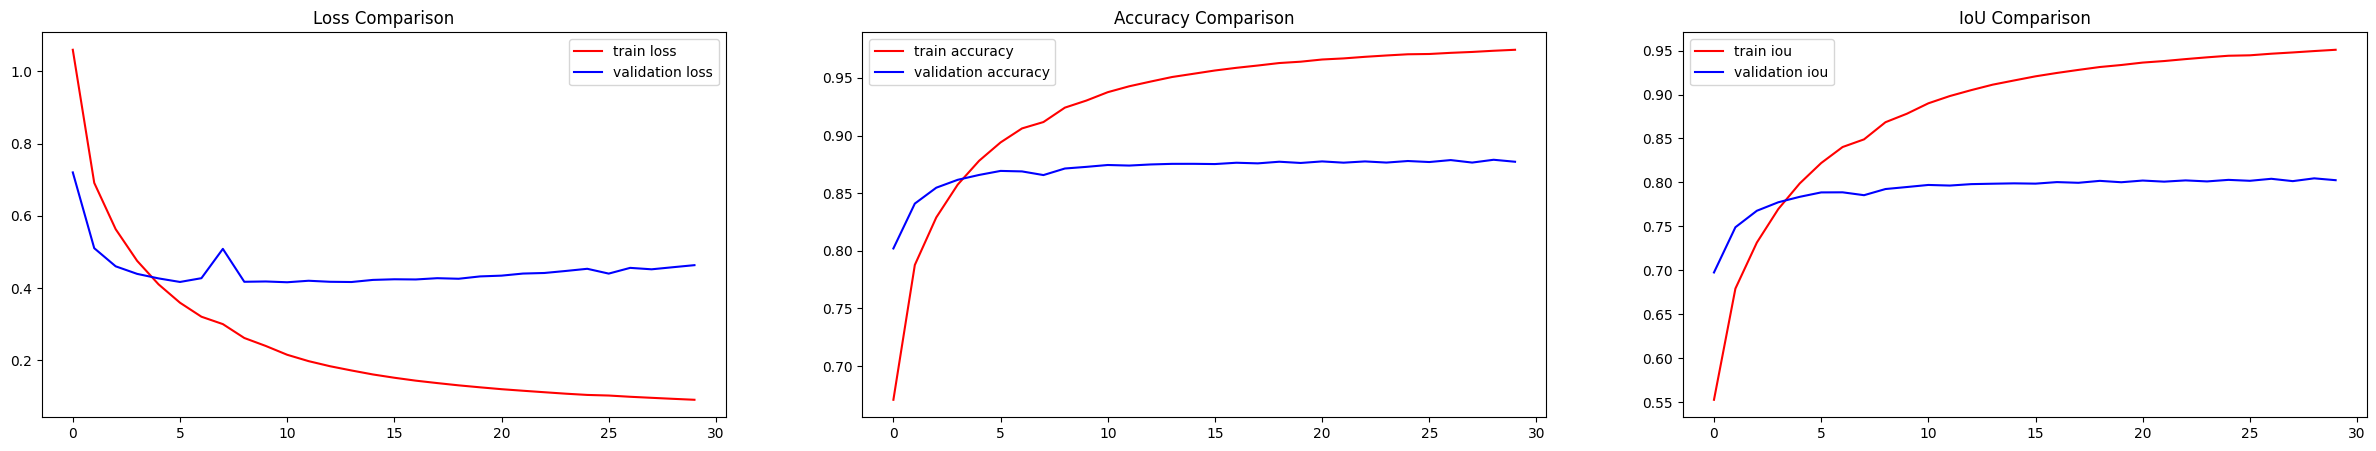

In [45]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_ce_sgd.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_ce_sgd.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_ce_sgd.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results_ce_sgd.history["val_accuracy"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_ce_sgd.history["iou"], color='r', label = 'train iou')
axis[2].plot(results_ce_sgd.history["val_iou"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Resultados del entrenamiento de los distintos modelos superpuestos

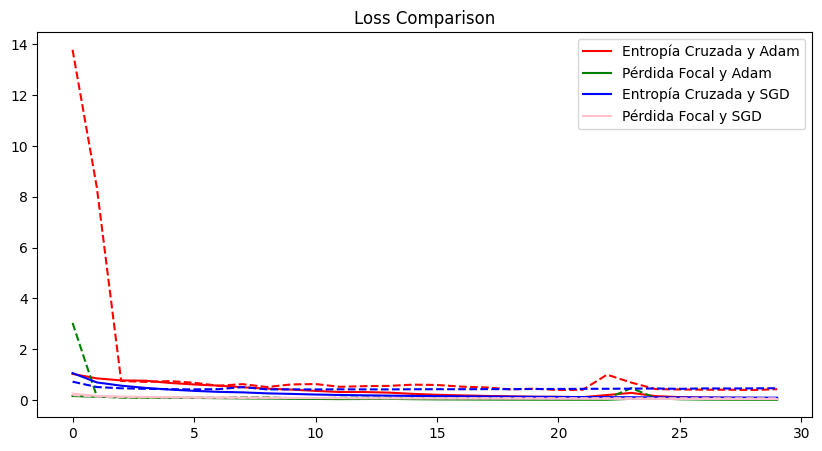

In [76]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_ce_adam.history["loss"], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(results_ce_adam.history["val_loss"], color='r', linestyle='--')
axis.plot(results_focal_adam.history["loss"], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(results_focal_adam.history["val_loss"], color='g', linestyle='--')
axis.plot(results_ce_sgd.history["loss"], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(results_ce_sgd.history["val_loss"], color='b', linestyle='--')
axis.plot(results_focal_sgd.history["loss"], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(results_focal_sgd.history["val_loss"], color='pink', linestyle='--')
axis.set_title('Loss Comparison')
axis.legend()

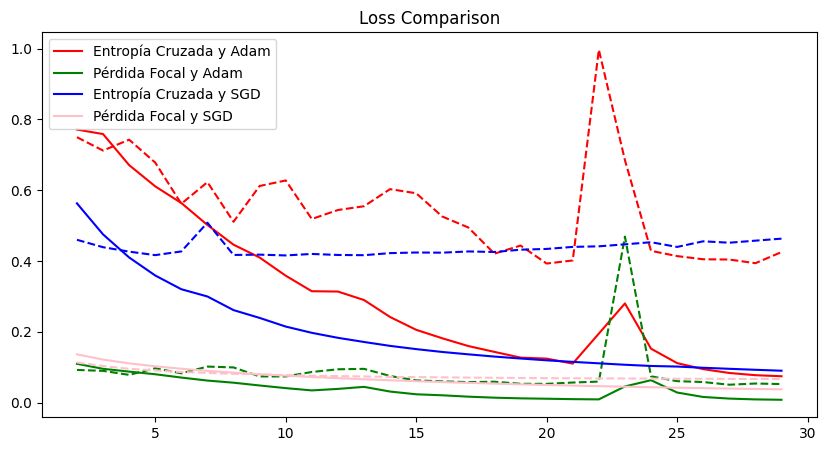

In [77]:
fig, axis = plt.subplots(figsize=(10, 5))
x_values = list(range(2, 2 + len(results_ce_adam.history["loss"][2:])))
axis.plot(x_values, results_ce_adam.history["loss"][2:], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(x_values, results_ce_adam.history["val_loss"][2:], color='r', linestyle='--')
axis.plot(x_values, results_focal_adam.history["loss"][2:], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(x_values, results_focal_adam.history["val_loss"][2:], color='g', linestyle='--')
axis.plot(x_values, results_ce_sgd.history["loss"][2:], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(x_values, results_ce_sgd.history["val_loss"][2:], color='b', linestyle='--')
axis.plot(x_values, results_focal_sgd.history["loss"][2:], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(x_values, results_focal_sgd.history["val_loss"][2:], color='pink', linestyle='--')
axis.set_title('Loss Comparison')
axis.legend()

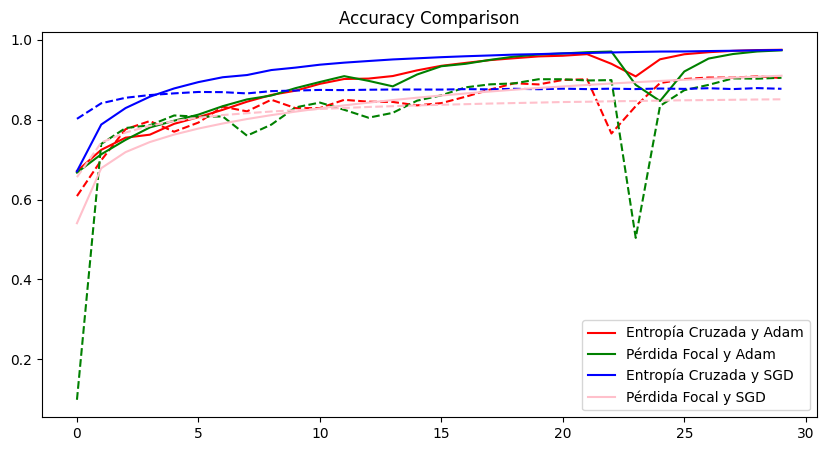

In [78]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_ce_adam.history["accuracy"], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(results_ce_adam.history["val_accuracy"], color='r', linestyle='--')
axis.plot(results_focal_adam.history["accuracy_one_hot"], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(results_focal_adam.history["val_accuracy_one_hot"], color='g', linestyle='--')
axis.plot(results_ce_sgd.history["accuracy"], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(results_ce_sgd.history["val_accuracy"], color='b', linestyle='--')
axis.plot(results_focal_sgd.history["accuracy_one_hot"], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(results_focal_sgd.history["val_accuracy_one_hot"], color='pink', linestyle='--')
axis.set_title('Accuracy Comparison')
axis.legend()

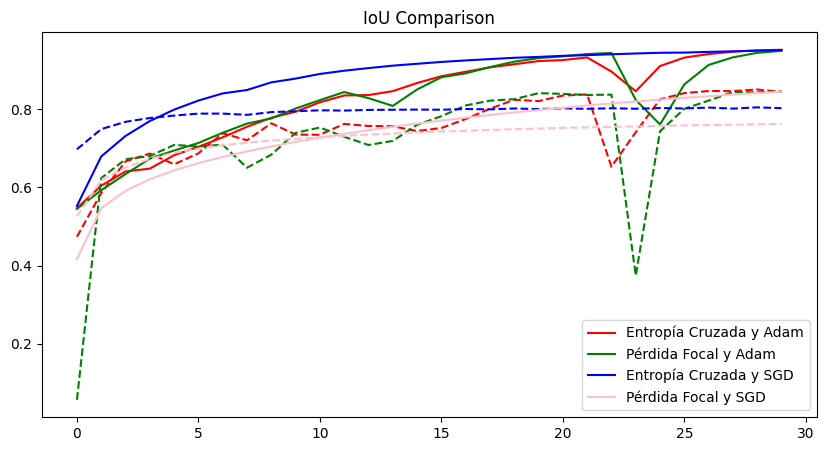

In [80]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_ce_adam.history["iou"], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(results_ce_adam.history["val_iou"], color='r', linestyle='--')
axis.plot(results_focal_adam.history["iou_one_hot"], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(results_focal_adam.history["val_iou_one_hot"], color='g', linestyle='--')
axis.plot(results_ce_sgd.history["iou"], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(results_ce_sgd.history["val_iou"], color='b', linestyle='--')
axis.plot(results_focal_sgd.history["iou_one_hot"], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(results_focal_sgd.history["val_iou_one_hot"], color='pink', linestyle='--')
axis.set_title('IoU Comparison')
axis.legend()

## Evaluación del modelo

In [51]:
def print_classes_score(score):
    print("\tFondo:\t\t\t{:.2f}".format(score[0] * 100))
    print("\tAcera:\t\t\t{:.2f}".format(score[1] * 100))
    print("\tBaldosas podotáctiles:\t{:.2f}".format(score[2] * 100))
    print("\tBanco:\t\t\t{:.2f}".format(score[3] * 100))
    print("\tCarretera:\t\t{:.2f}".format(score[4] * 100))
    print("\tPared:\t\t\t{:.2f}".format(score[5] * 100))
    print("\tPaso de cebra:\t\t{:.2f}".format(score[6] * 100))
    print("\tVegetación:\t\t{:.2f}".format(score[7] * 100))
    return

### Pérdida focal y Adam

In [81]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_focal_adam.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 21ms/step


In [82]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

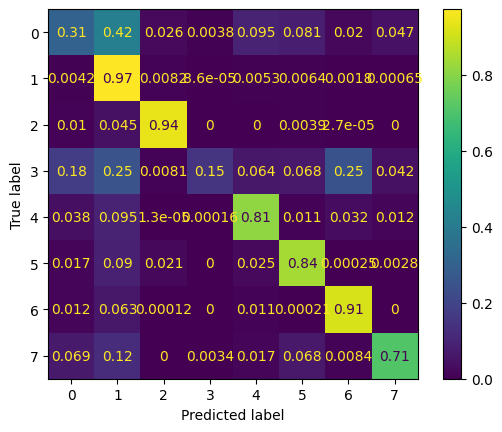

In [83]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [84]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 90.36
global accuracy: 90.36
global precision: 90.36
global recall: 90.36
global iou: 82.42
----------------------------------
weighted dice_coef: 89.75
weighted precision: 89.78
weighted recall: 90.36
weighted iou: 83.07
----------------------------------
Dice_coef per class: 
	Fondo:			36.01
	Acera:			94.87
	Baldosas podotáctiles:	90.80
	Banco:			25.10
	Carretera:		83.28
	Pared:			85.63
	Paso de cebra:		93.17
	Vegetación:		77.92
Precision per class: 
	Fondo:			43.55
	Acera:			92.54
	Baldosas podotáctiles:	87.71
	Banco:			82.52
	Carretera:		85.44
	Pared:			86.91
	Paso de cebra:		95.06
	Vegetación:		86.27
Recall per class: 
	Fondo:			30.69
	Acera:			97.33
	Baldosas podotáctiles:	94.13
	Banco:			14.80
	Carretera:		81.23
	Pared:			84.39
	Paso de cebra:		91.36
	Vegetación:		71.05
IoU per class: 
	Fondo:			21.96
	Acera:			90.25
	Baldosas podotáctiles:	83.16
	Banco:			14.35
	Carretera:		71.35
	Pared:			74.88
	Paso de cebra:		87.21
	Vegeta

### Pérdida focal y SGD

In [56]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_focal_sgd.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 20ms/step


In [57]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

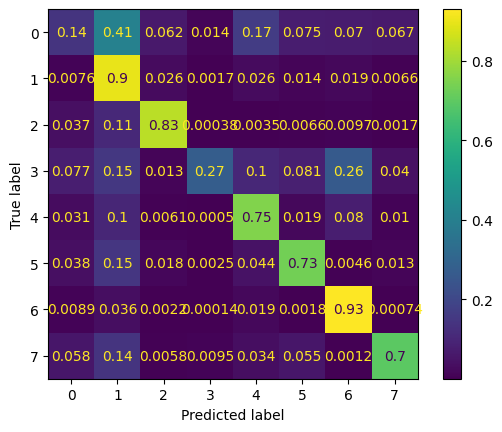

In [58]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [59]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 83.88
global accuracy: 83.88
global precision: 83.88
global recall: 83.88
global iou: 72.24
----------------------------------
weighted dice_coef: 83.45
weighted precision: 83.33
weighted recall: 83.88
weighted iou: 73.64
----------------------------------
Dice_coef per class: 
	Fondo:			17.15
	Acera:			90.59
	Baldosas podotáctiles:	76.26
	Banco:			36.81
	Carretera:		70.93
	Pared:			76.02
	Paso de cebra:		88.95
	Vegetación:		70.55
Precision per class: 
	Fondo:			22.22
	Acera:			91.34
	Baldosas podotáctiles:	70.23
	Banco:			55.67
	Carretera:		67.04
	Pared:			79.17
	Paso de cebra:		85.18
	Vegetación:		71.62
Recall per class: 
	Fondo:			13.96
	Acera:			89.85
	Baldosas podotáctiles:	83.41
	Banco:			27.50
	Carretera:		75.30
	Pared:			73.11
	Paso de cebra:		93.07
	Vegetación:		69.52
IoU per class: 
	Fondo:			9.38
	Acera:			82.79
	Baldosas podotáctiles:	61.63
	Banco:			22.56
	Carretera:		54.96
	Pared:			61.31
	Paso de cebra:		80.10
	Vegetac

### Entropía cruzada categórica dispersa y Adam

In [60]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_ce_adam.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 22ms/step


In [61]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

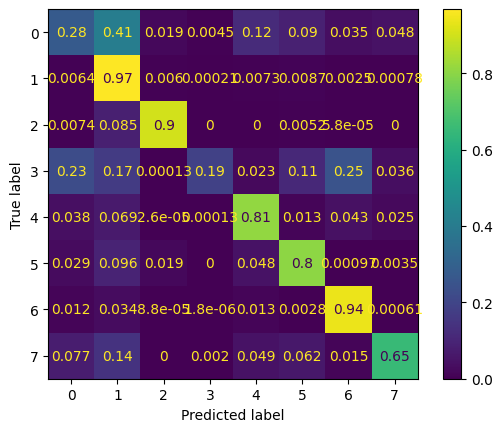

In [62]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [63]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 89.63
global accuracy: 89.63
global precision: 89.63
global recall: 89.63
global iou: 81.21
----------------------------------
weighted dice_coef: 89.07
weighted precision: 89.04
weighted recall: 89.63
weighted iou: 82.22
----------------------------------
Dice_coef per class: 
	Fondo:			31.28
	Acera:			94.92
	Baldosas podotáctiles:	90.11
	Banco:			30.52
	Carretera:		80.78
	Pared:			81.91
	Paso de cebra:		93.84
	Vegetación:		72.40
Precision per class: 
	Fondo:			36.26
	Acera:			93.10
	Baldosas podotáctiles:	89.95
	Banco:			83.71
	Carretera:		80.39
	Pared:			83.53
	Paso de cebra:		93.85
	Vegetación:		81.29
Recall per class: 
	Fondo:			27.50
	Acera:			96.81
	Baldosas podotáctiles:	90.27
	Banco:			18.66
	Carretera:		81.16
	Pared:			80.35
	Paso de cebra:		93.83
	Vegetación:		65.26
IoU per class: 
	Fondo:			18.54
	Acera:			90.33
	Baldosas podotáctiles:	81.99
	Banco:			18.01
	Carretera:		67.75
	Pared:			69.37
	Paso de cebra:		88.39
	Vegeta

### Entropía cruzada categóriza dispersa y SGD

In [64]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_ce_sgd.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 20ms/step


In [65]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

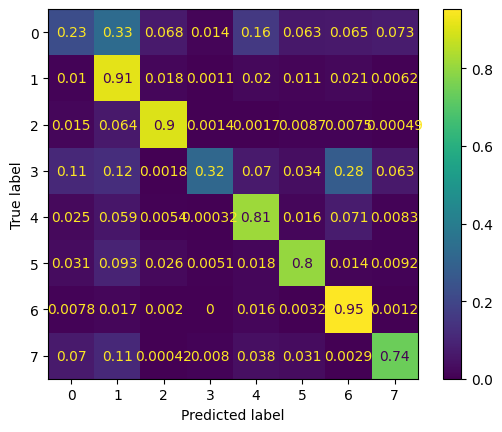

In [66]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [67]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 86.89
global accuracy: 86.89
global precision: 86.89
global recall: 86.89
global iou: 76.82
----------------------------------
weighted dice_coef: 86.58
weighted precision: 86.61
weighted recall: 86.89
weighted iou: 78.04
----------------------------------
Dice_coef per class: 
	Fondo:			26.43
	Acera:			92.66
	Baldosas podotáctiles:	82.83
	Banco:			42.10
	Carretera:		77.64
	Pared:			82.19
	Paso de cebra:		89.82
	Vegetación:		73.82
Precision per class: 
	Fondo:			31.90
	Acera:			94.10
	Baldosas podotáctiles:	76.63
	Banco:			62.08
	Carretera:		74.14
	Pared:			84.08
	Paso de cebra:		84.93
	Vegetación:		73.66
Recall per class: 
	Fondo:			22.56
	Acera:			91.26
	Baldosas podotáctiles:	90.11
	Banco:			31.85
	Carretera:		81.49
	Pared:			80.38
	Paso de cebra:		95.30
	Vegetación:		73.99
IoU per class: 
	Fondo:			15.23
	Acera:			86.32
	Baldosas podotáctiles:	70.69
	Banco:			26.66
	Carretera:		63.45
	Pared:			69.77
	Paso de cebra:		81.52
	Vegeta

## Visualización de predicciones

In [70]:
def VisualizeResults(index):
    img = X_test[index]
    img = img[np.newaxis, ...]
    pred_y = model_focal_adam.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask_color = label_to_color_image(pred_mask).astype(np.uint8)
    truth_mask_color = label_to_color_image(y_test[index,:,:,0]).astype(np.uint8)
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_test[index]/255.0)
    arr[0].set_title('Imagen preprocesada')
    arr[1].imshow(truth_mask_color)
    arr[1].set_title('Máscara real')
    arr[2].imshow(pred_mask_color)
    arr[2].set_title('Máscara predicha')

1/1 [==============================] - 0s 21ms/step


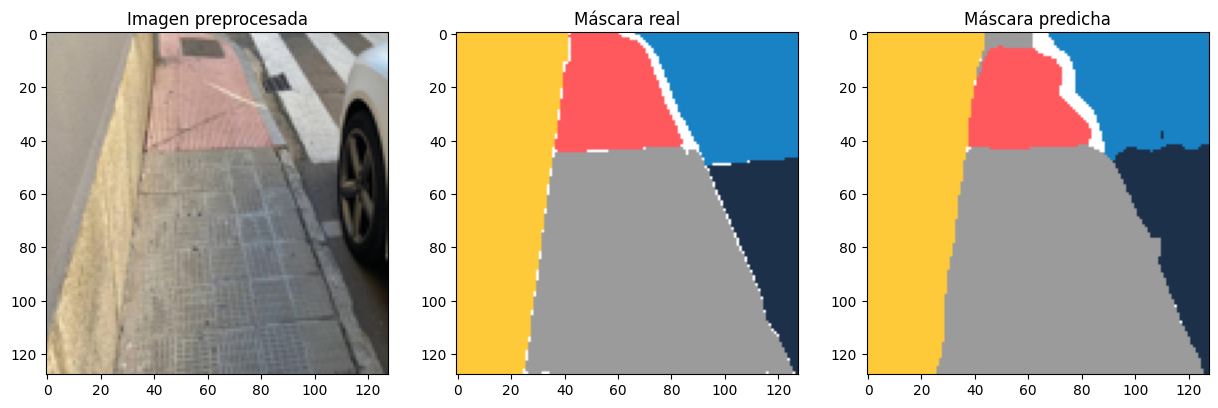

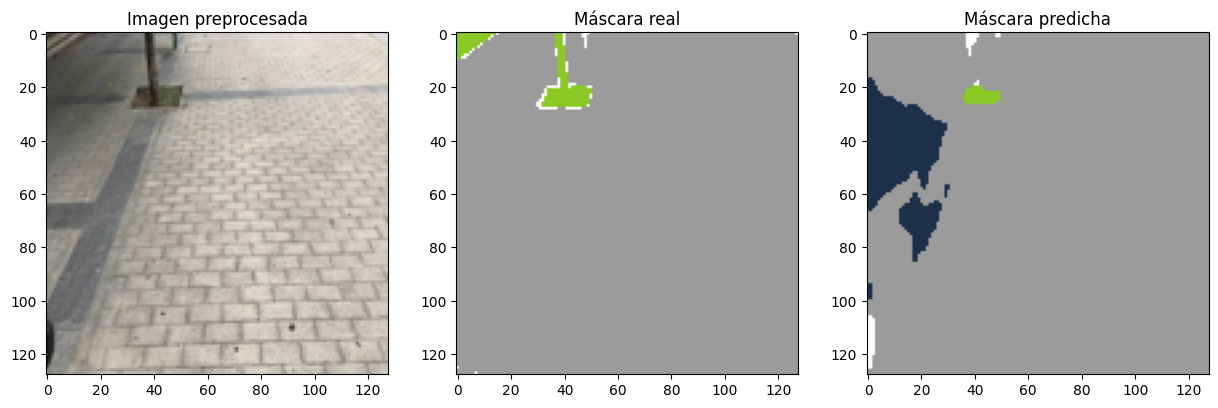

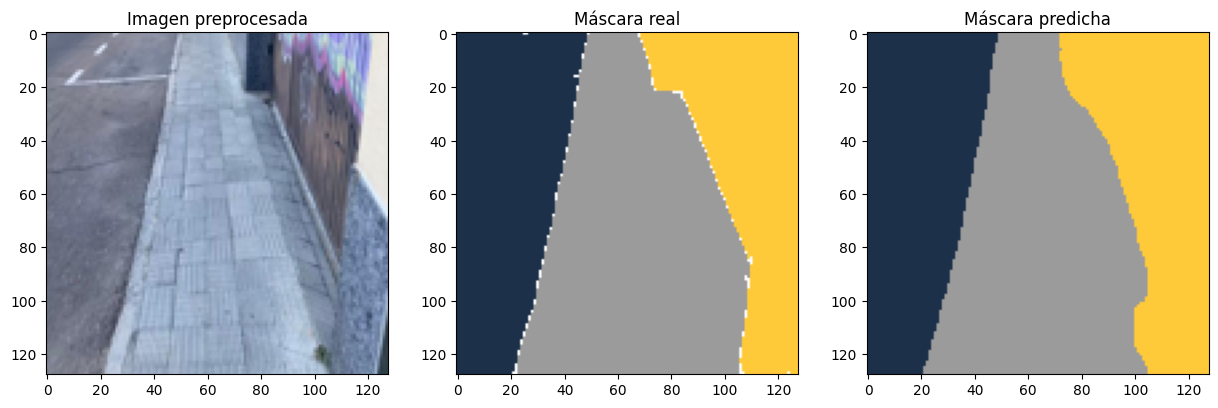

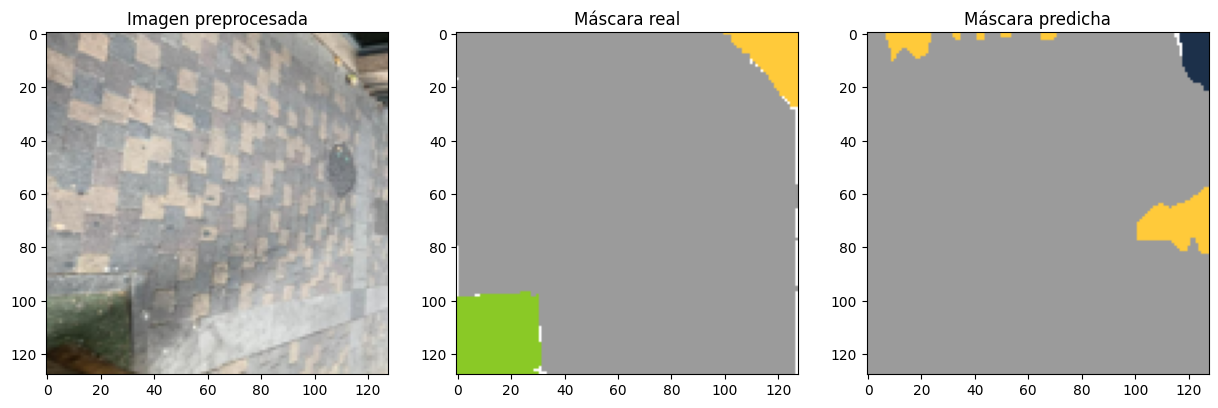

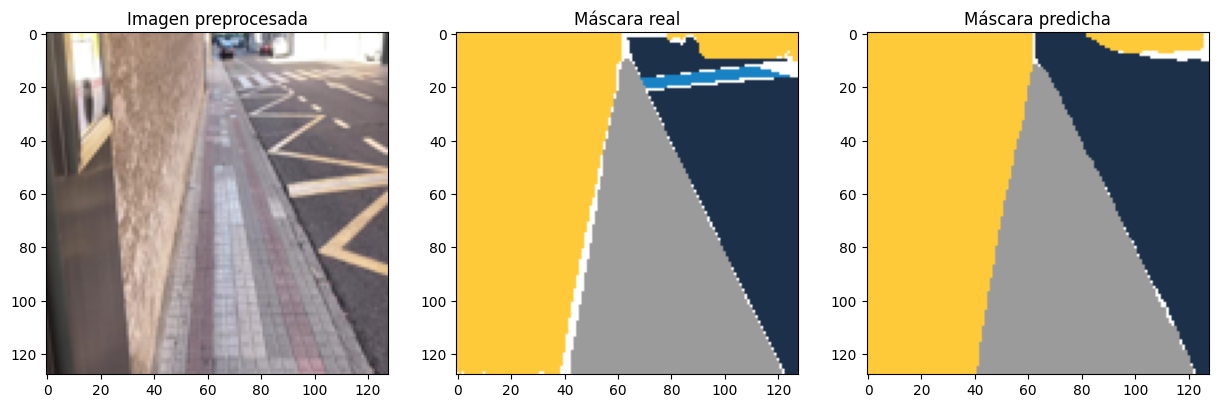

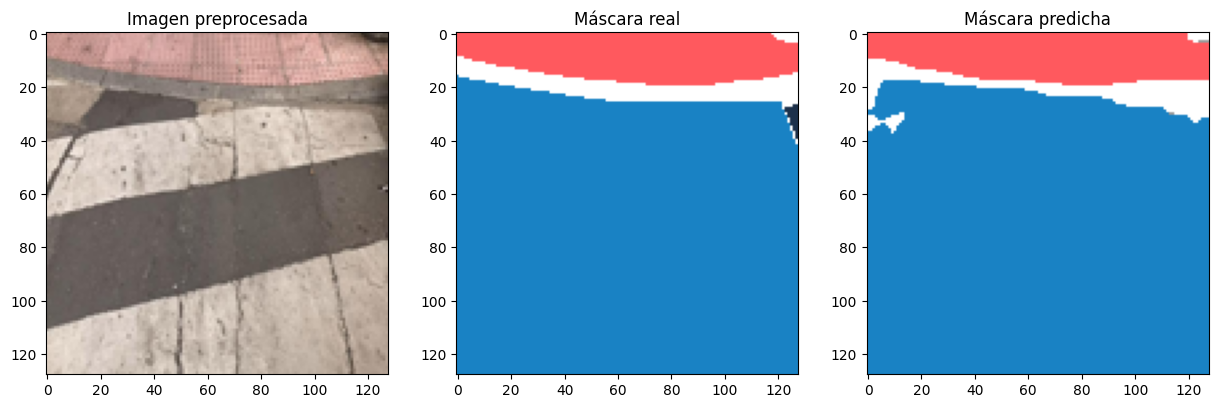

In [71]:
show_images = 6
random_ints = np.random.randint(0, NUM_TEST_IMAGES - 1, size=show_images)
for num in random_ints:
    VisualizeResults(num)

## Descarga del modelo entrenado

In [ ]:
#model.save('/content/modelo_SegNet.keras')
#files.download("/content/modelo_SegNet.keras")